# Fase 1 — Árbol de Decisión (XAI · Unidad 2)

**Autores:** Jordi Florit Ensenyat · Josep Gabriel Fornes Reynes · Juan Esteban Rincón Marín  
**Asignatura:** Inteligencia Artificial Explicable — Hands-on Project (U2)  
**Fecha:** 28-09-2025

In [4]:
import sys
if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
!pip install interpret six graphviz pydotplus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.8 MB/s eta 0:00:00


# Exploración inicial de los datos
Antes de entrenar el modelo, queremos entender la estructura del dataset:
- Número de instancias y variables (`df.info()`).
- Tipos de variables (categóricas, numéricas, binarias).
- Distribución de la variable objetivo (¿balanceada o desbalanceada?).

Esto nos ayuda a anticipar posibles problemas en el modelo, como sesgo hacia la clase mayoritaria.


In [6]:
import pandas as pd

df = pd.read_csv("recidivism.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222 entries, 0 to 4221
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sex                    4222 non-null   int64 
 1   age                    4222 non-null   int64 
 2   juv_fel_count          4222 non-null   int64 
 3   juv_misd_count         4222 non-null   int64 
 4   juv_other_count        4222 non-null   int64 
 5   priors_count           4222 non-null   int64 
 6   race_African-American  4222 non-null   int64 
 7   race_Caucasian         4222 non-null   int64 
 8   c_charge_degree_F      4222 non-null   int64 
 9   c_charge_degree_M      4222 non-null   int64 
 10  employment             4222 non-null   object
 11  recid                  4222 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 395.9+ KB


,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race_African-American,race_Caucasian,c_charge_degree_F,c_charge_degree_M,employment,recid
0,0,45,0,0,0,1,0,1,1,0,unemployed,1
1,1,43,0,0,0,2,1,0,0,1,unemployed,0
2,0,26,0,0,0,0,1,0,1,0,employed,0
3,1,35,0,0,0,1,0,1,1,0,unemployed,1
4,1,27,0,0,0,0,1,0,1,0,unemployed,1


## División de datos (train-test) y Definición del Modelo Base

En esta sección, preparamos los datos para el entrenamiento del modelo y definimos la estructura básica del clasificador de árbol de decisión.

1.  **División de Datos:** Dividimos el dataset en conjuntos de entrenamiento y prueba (`X_train`, `X_test`, `y_train`, `y_test`). La división se realiza utilizando `train_test_split` con un 30% de los datos para prueba y estratificación por la variable objetivo (`recid`) para mantener las proporciones de clase.

2.  **Definición del Modelo Base:** Importamos `DecisionTreeClassifier` de scikit-learn. Aunque en este punto aún no hemos definido los hiperparámetros óptimos, preparamos la importación de la función necesaria para la construcción del modelo.

In [22]:
# --- Bibliotecas de manipulación de datos y numéricas ---
import numpy as np
import pandas as pd

# --- Bibliotecas de visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Componentes de Scikit-Learn ---
# Preprocesamiento y selección de modelos
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# Modelos
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# Métricas de evaluación
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

# --- Biblioteca InterpretML para explicabilidad ---
from interpret import show
from interpret.glassbox import (ClassificationTree,
                                  ExplainableBoostingClassifier)

In [3]:
# Definir target y variables predictoras
X = df.drop(columns=["recid"])   # Todas las columnas menos la variable objetivo
y = df["recid"]

# Dividir en train (70%) y test/valid (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,         # porcentaje para el test
    random_state=42,        # semilla para reproducibilidad
    stratify=y              # asegura que las proporciones de clases se mantengan
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2955, 11) (2955,)
Test shape: (1267, 11) (1267,)


# Preprocesamiento de los datos
En este paso definimos:
- **Variables categóricas**: se codifican mediante *OneHotEncoder*.
- **Variables numéricas**: no requieren escalado para árboles, pero podrían normalizarse si se combinan con otros algoritmos.
- **Pipeline**: asegura que todo el flujo (preprocesamiento + modelo) se ejecute de forma coherente en entrenamiento y test.

In [ ]:
# Preprocesamiento: numéricas (passthrough), categóricas (One-Hot)
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Logical classifiers
- tree
- lists
- sets

# Decision Tree Classifier

In [ ]:
# Pipeline: preprocesamiento + modelo
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("dt", DecisionTreeClassifier(random_state=42))
])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## Decision Tree Classifier simple
Entrenamos un primer modelo base (sin tuning) para establecer un punto de comparación.
Este baseline nos permitirá medir cuánto mejora el rendimiento tras aplicar **GridSearchCV**.


Accuracy (valid): 0.6590

== Classification report (valid) ==
              precision    recall  f1-score   support

           0       0.67      0.72      0.69       674
           1       0.65      0.59      0.62       593

    accuracy                           0.66      1267
   macro avg       0.66      0.65      0.65      1267
weighted avg       0.66      0.66      0.66      1267

== Confusion matrix (valid) ==


[]

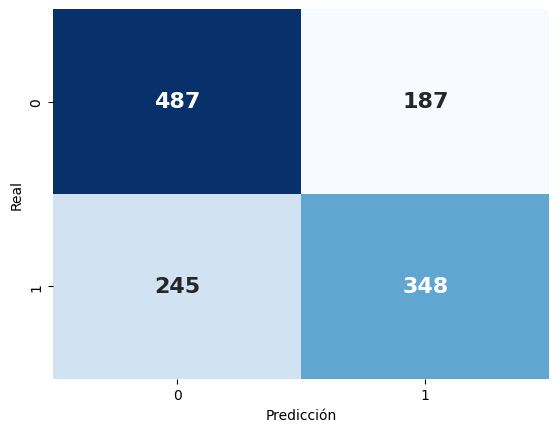

In [ ]:
# Entrenar
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (valid): {acc:.4f}\n")

print("== Classification report (valid) ==")
print(classification_report(y_test, y_pred))

print("== Confusion matrix (valid) ==")
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16, "weight": "bold"});ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.plot()

In [ ]:
# Asumiendo que ya tienes entrenado el árbol en 'model'
# Access the DecisionTreeClassifier from the pipeline
decision_tree_model = clf.named_steps['dt']

# Get feature names after preprocessing
# This requires fitting the preprocessor separately or getting feature names from the pipeline
# For simplicity, let's use the original feature names for now, but be aware of one-hot encoding
# A more robust solution would involve getting feature names from the preprocessor after fitting

# Get feature names from the preprocessor after fitting
# This is a bit more complex because OneHotEncoder changes the feature names
# A simpler approach for visualization might be to use the original feature names
# but the visualization won't reflect the one-hot encoded features

# Let's use the feature names from the fitted preprocessor
try:
    # This works for newer versions of scikit-learn
    feature_names_out = clf.named_steps['prep'].get_feature_names_out(X.columns)
except AttributeError:
    # Fallback for older versions - might not be perfect
    feature_names_out = list(X.columns)


rules = export_text(decision_tree_model, feature_names=list(feature_names_out))
print(rules)

In [ ]:
# Aseguramos nombres de clase legibles (en el mismo orden que usa el modelo)
classes_ = getattr(decision_tree_model, "classes_", None)
if classes_ is None:
    # fallback por si acaso
    classes_ = np.unique(y_train)

plt.figure(figsize=(18, 12))
plot_tree(
    decision_tree_model,
    feature_names=feature_names_out,        # nombres tras One-Hot/ColumnTransformer
    class_names=[str(c) for c in classes_], # etiquetas de clase
    filled=True,
    rounded=True,
    impurity=True,      # gini/entropy en nodos (puedes poner False si lo quieres más limpio)
    proportion=True,    # muestra proporción de muestras por nodo
    fontsize=9
)
plt.title("Árbol de Decisión (con features tras One-Hot)")
plt.tight_layout()
plt.show()


Como podemos ver, el árbol resultante no es nada explicable. Además, no nos da muy buenos resultados.

## GridSearchCV y validación cruzada
- Usamos validación cruzada estratificada (5 folds) para garantizar que las proporciones de clases se mantengan.  
- Buscamos entre distintos hiperparámetros (`criterion`, `max_depth`, `min_samples_split`, etc.).  
- El mejor modelo se selecciona en base a la métrica de **balanced accuracy**, que es más robusta en datasets desbalanceados.


Fitting 5 folds for each of 4032 candidates, totalling 20160 fits
Mejores parámetros: {'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__max_features': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2, 'dt__splitter': 'best'}
Mejor CV (balanced_acc): 0.7191
Accuracy (test): 0.6961
Balanced Acc (test): 0.7019

== Classification report (test) ==
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       674
           1       0.64      0.79      0.71       593

    accuracy                           0.70      1267
   macro avg       0.71      0.70      0.70      1267
weighted avg       0.71      0.70      0.69      1267

== Confusion matrix (test) ==


[]

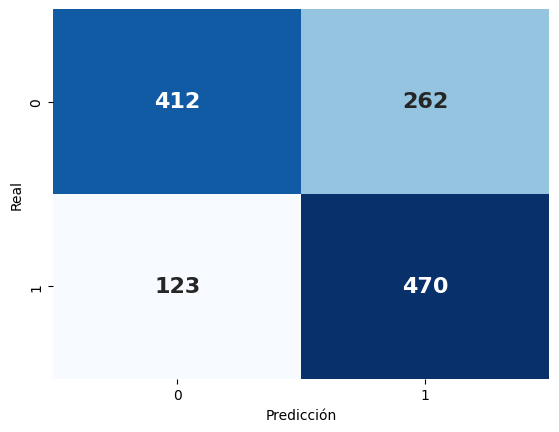

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Esquema de CV estratificado (pide 5-fold en el enunciado)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Rejilla de hiperparámetros del árbol (ajústala si el tiempo es justo)
param_grid = {
    "dt__criterion": ["gini", "entropy", "log_loss"],
    "dt__max_depth": [None, 3, 4, 5, 6, 8, 10],
    "dt__min_samples_split": [2, 5, 10, 20],
    "dt__min_samples_leaf": [1, 2, 5, 10],
    "dt__max_features": [None, "sqrt", "log2"],  # sólo sobre features ya preprocesadas
    "dt__class_weight": [None, "balanced"],      # útil si hay desbalanceo
    "dt__splitter": ["best", "random"]
}

# Métrica: si es binaria y hay desbalanceo, usa balanced_accuracy o roc_auc
grid = GridSearchCV(
    estimator=clf,                # tu Pipeline (prep + dt)
    param_grid=param_grid,
    scoring="balanced_accuracy",  # cambia a "roc_auc" si prefieres AUC
    n_jobs=-1,
    cv=cv,
    refit=True,                   # deja el mejor modelo refitteado en .best_estimator_
    verbose=1,
    return_train_score=True
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print(f"Mejor CV (balanced_acc): {grid.best_score_:.4f}")

# Evalúa SÓLO ahora en test (hold-out)
best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
print(f"Accuracy (test): {accuracy_score(y_test, y_pred):.4f}")
print(f"Balanced Acc (test): {balanced_accuracy_score(y_test, y_pred):.4f}")
print("\n== Classification report (test) ==")
print(classification_report(y_test, y_pred))
print("== Confusion matrix (test) ==")
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16, "weight": "bold"});ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.plot()


### Visualización de árbol

|--- cat__employment_unemployed <= 0.50
|   |--- num__priors_count <= 20.00
|   |   |--- num__sex <= 0.50
|   |   |   |--- class: 0
|   |   |--- num__sex >  0.50
|   |   |   |--- class: 0
|   |--- num__priors_count >  20.00
|   |   |--- class: 1
|--- cat__employment_unemployed >  0.50
|   |--- num__priors_count <= 2.50
|   |   |--- num__age <= 28.50
|   |   |   |--- class: 1
|   |   |--- num__age >  28.50
|   |   |   |--- class: 0
|   |--- num__priors_count >  2.50
|   |   |--- num__age <= 36.50
|   |   |   |--- class: 1
|   |   |--- num__age >  36.50
|   |   |   |--- class: 1



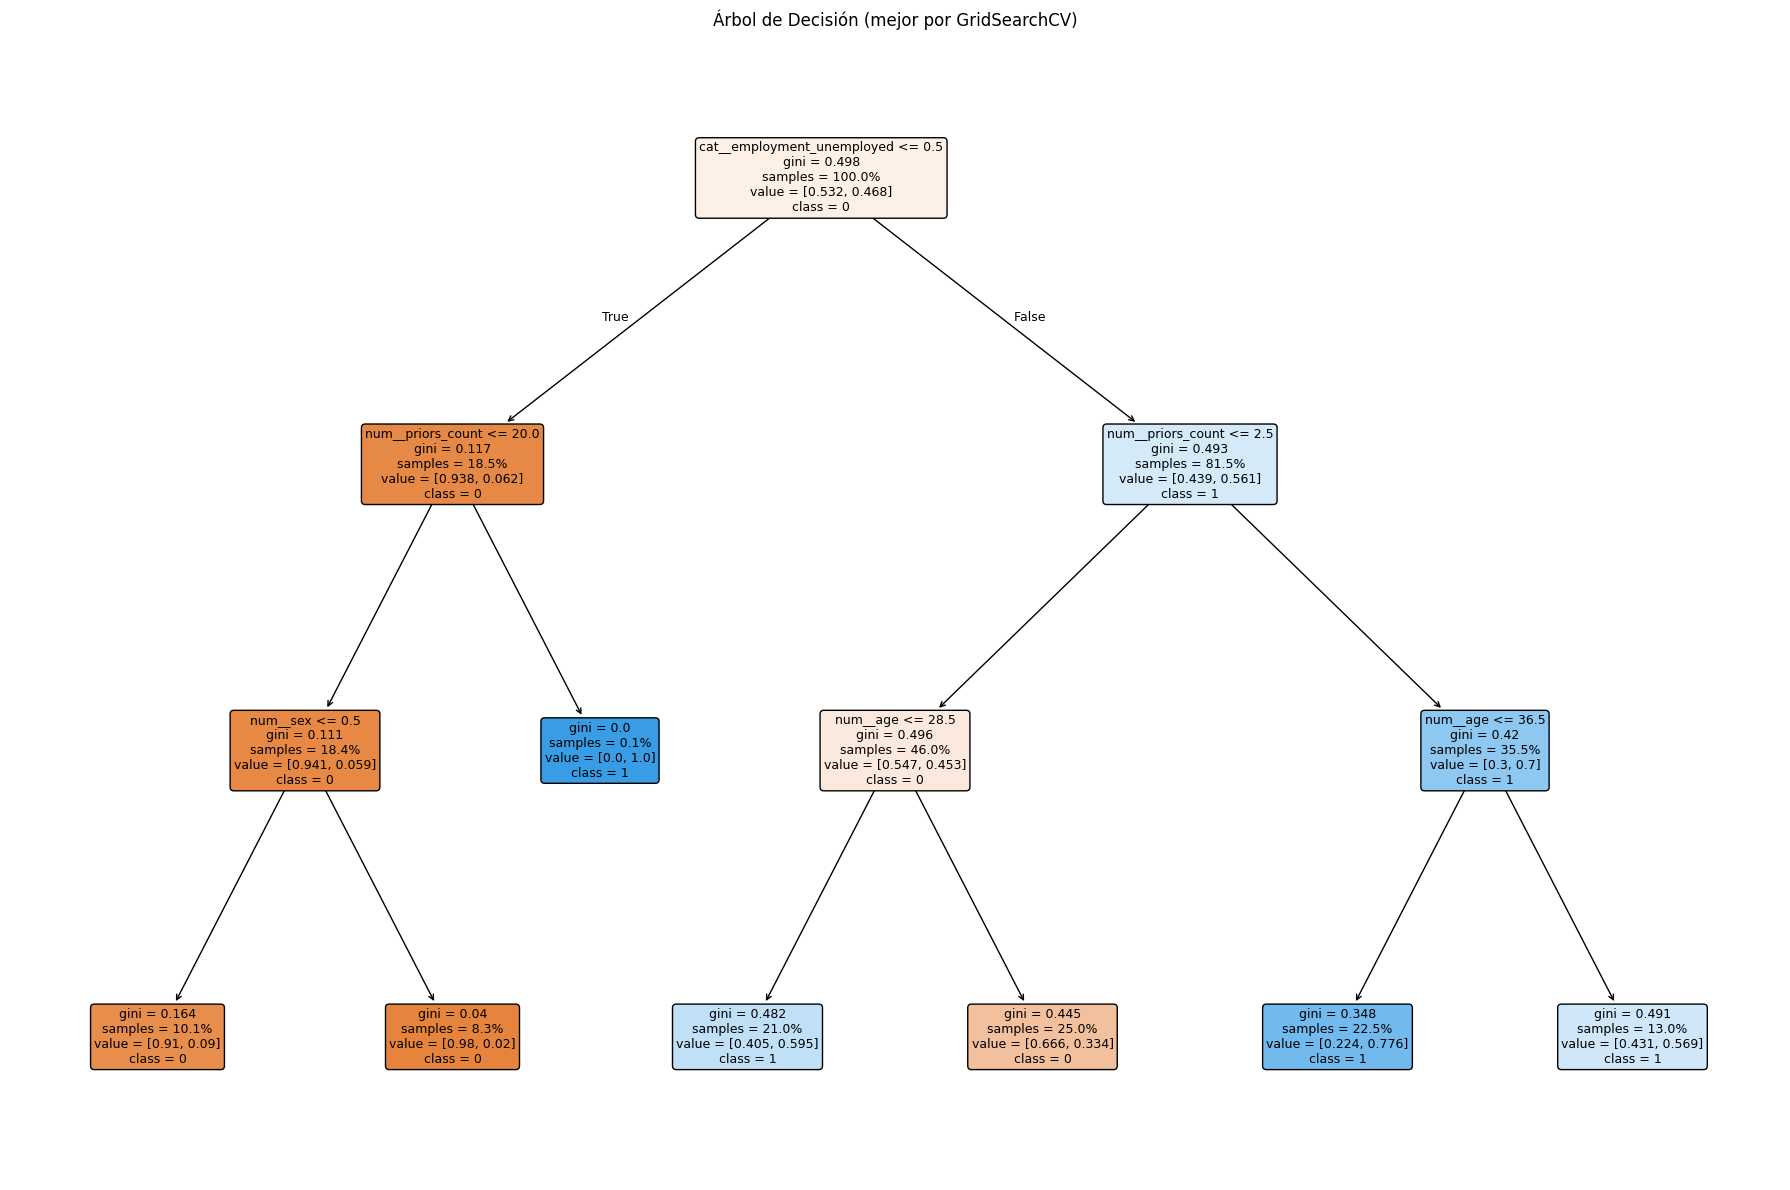

In [ ]:
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import numpy as np

best_dt = best_clf.named_steps["dt"]

# Nombres de features tras el preprocesado
feature_names_out = best_clf.named_steps["prep"].get_feature_names_out(X.columns)

# Reglas en texto
print(export_text(best_dt, feature_names=list(feature_names_out)))

# Plot
classes_ = getattr(best_dt, "classes_", np.unique(y_train))
plt.figure(figsize=(18, 12))
plot_tree(
    best_dt,
    feature_names=feature_names_out,
    class_names=[str(c) for c in classes_],
    filled=True, rounded=True, impurity=True, proportion=True, fontsize=9
)
plt.title("Árbol de Decisión (mejor por GridSearchCV)")
plt.tight_layout()
plt.show()


In [ ]:
# 1) Extrae los hiperparámetros del árbol del GridSearch (prefijo dt__)
best_dt_params = {k.split("dt__")[1]: v for k, v in grid.best_params_.items() if k.startswith("dt__")}

# 2) Filtra solo los compatibles con ClassificationTree de interpret
allowed = {"max_depth", "min_samples_split", "min_samples_leaf"}
ct_params = {k: v for k, v in best_dt_params.items() if k in allowed}
ct_params.setdefault("random_state", 42)

# 3) Preprocesa X con 'prep' del pipeline ganador
prep = best_clf.named_steps["prep"]
Xtr_num = prep.transform(X_train)   # -> array/CSR con one-hot + numéricas
Xte_num = prep.transform(X_test)

# 4) Poner nombres de columnas para que las explicaciones sean legibles
import pandas as pd
feat_out = prep.get_feature_names_out(X_train.columns)
Xtr_df = pd.DataFrame(Xtr_num.toarray() if hasattr(Xtr_num, "toarray") else Xtr_num, columns=feat_out)
Xte_df = pd.DataFrame(Xte_num.toarray() if hasattr(Xte_num, "toarray") else Xte_num, columns=feat_out)

# 5) Entrenar el árbol de interpret con los mismos hiperparámetros compatibles
from interpret.glassbox import ClassificationTree
ct = ClassificationTree(**ct_params)
ct.fit(Xtr_df, y_train)

In [ ]:
# Añadir exolicabilidad local
from interpret import show
global_exp = ct.explain_global(name="ClassificationTree · Global")
show(global_exp)

## Explicabilidad global

El árbol de decisión aprendido genera reglas claras y fáciles de explicar:

1. **Situación laboral (`employment_unemployed`)**  
   - Es la variable en la **raíz**, por tanto, la más influyente.  
   - Si el individuo **no está desempleado** (≤ 0.5), la predicción tiende a ser **clase 0 (no reincide)** salvo casos extremos.  
   - Si el individuo **está desempleado** (> 0.5), la rama principal se orienta hacia **clase 1 (reincide)** con matices según edad y antecedentes.

2. **Número de antecedentes (`num__priors_count`)**  
   - Si una persona con empleo tiene **más de 20 antecedentes**, se clasifica directamente como **clase 1 (reincide)**.  
   - En desempleados, el umbral se sitúa mucho más bajo (**2.5 antecedentes**) para diferenciar perfiles de bajo y alto riesgo.

3. **Edad (`num__age`)**  
   - Aparece en la rama de los desempleados:  
     - **≤ 28.5 años** con pocos antecedentes ⇒ **clase 1** (riesgo alto por juventud).  
     - **> 28.5 años** con pocos antecedentes ⇒ **clase 0** (la edad mitiga el riesgo).  
     - Con más antecedentes, incluso los **mayores de 36.5 años** siguen siendo clasificados como reincidentes.

4. **Sexo (`num__sex`)**  
   - Aparece solo en la rama de personas empleadas con ≤ 20 antecedentes.  
   - Tanto hombres como mujeres terminan siendo clasificados como **clase 0**, aunque el nodo ajusta ligeramente la pureza.

**Reglas principales extraídas:**

- **R1.** Si `employment_unemployed ≤ 0.5` y `num__priors_count ≤ 20` ⇒ **Clase 0 (no reincide)**.  
- **R2.** Si `employment_unemployed ≤ 0.5` y `num__priors_count > 20` ⇒ **Clase 1 (reincide)**.  
- **R3.** Si `employment_unemployed > 0.5` y `num__priors_count ≤ 2.5`:  
  - Si `edad ≤ 28.5` ⇒ **Clase 1**.  
  - Si `edad > 28.5` ⇒ **Clase 0**.  
- **R4.** Si `employment_unemployed > 0.5` y `num__priors_count > 2.5`:  
  - Si `edad ≤ 36.5` ⇒ **Clase 1**.  
  - Si `edad > 36.5` ⇒ **Clase 1** (con mayor incertidumbre).

**Ranking de importancia (inferido):**
1. Situación laboral  
2. N.º de antecedentes  
3. Edad  
4. Sexo (mínima relevancia)

### Explicabilidad local
Para un caso individual, podemos seguir la ruta de decisión:
- Ver qué reglas se aplican en cada nodo.
- Entender por qué la predicción final es positiva o negativa.

Esto aporta **explicabilidad local**.

Para este apartado usamos el árbol de **InterpretMl**, para poder usar el metodo _explain_local()_ necesitamos entrenar un árbol entrenado de la libreria **InterpretMl** con los mejores parámetros encontrados en el greed-search.


In [ ]:
# Añadir exolicabilidad local
local_exp = ct.explain_local(Xte_df.iloc[:5], y_test.iloc[:5], name="ClassificationTree · Local (5 casos)")
show(local_exp)


Ahora podemos observar 5 ejemplos reales de test, la clase que se ha predecido, la real y las reglas que se ha seguido en cada caso.

## Caso 0 — *Falso positivo*
**0 : Actual (0) | Predicted (1) | PrScore 0.776**

**Ruta seguida:**
1. `unemployed = 1` (rama derecha).
2. `num__priors_count <= 2.50` (pocos antecedentes).
3. `num__age <= 36.50` → hoja **naranja (clase 1)**.

**Lectura:** El modelo **sube el riesgo** (1) cuando la persona está **desempleada**, tiene **pocos antecedentes** y es **≤ 36.5 años**. Aquí se **equivoca** (era 0) pero con **confianza alta** (0.776).

## Caso 1 — *Verdadero negativo*
**1 : Actual (0) | Predicted (0) | PrScore 0.666**

**Ruta seguida:**
1. `unemployed = 1`.
2. `num__priors_count <= 2.50`.
3. `num__age <= 28.50` → hoja **azul (clase 0)**.

**Lectura:** Dentro de *desempleados + pocos antecedentes*, si la **edad es muy baja (≤ 28.5)** el árbol **baja el riesgo** y clasifica como 0.

## Caso 2 — *Verdadero positivo*
**2 : Actual (1) | Predicted (1) | PrScore 0.776**

**Ruta seguida:**
1. `unemployed = 1`.
2. `num__priors_count <= 2.50`.
3. `num__age <= 36.50` → **clase 1**.

**Lectura:** Misma subregla que en el Caso 0, pero aquí **acierta**: *desempleo + juventud relativa* activan 1 incluso con pocos antecedentes.

## Caso 3 — *Falso negativo*
**3 : Actual (1) | Predicted (0) | PrScore 0.666**

**Ruta seguida:**
1. `unemployed = 1`.
2. `num__priors_count <= 2.50`.
3. `num__age <= 28.50` → **clase 0**.

**Lectura:** Igual que el Caso 1, pero la verdad era 1. La subregla “**muy joven (≤ 28.5)**, **pocos antecedentes**, **desempleado**” **tiende a infraestimar** el riesgo en algunos casos.

## Caso 4 — *Verdadero negativo*
**4 : Actual (0) | Predicted (0) | PrScore 0.666**

**Ruta seguida:**
1. `unemployed = 1`.
2. `num__priors_count <= 2.50`.
3. `num__age <= 28.50` → **clase 0**.

**Lectura:** Repite el patrón de **baja edad → clase 0** dentro del subgrupo *desempleado + pocos antecedentes*.



# List classifier

In [ ]:
!pip -q install -U imodels


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
# 1) IMPORTS
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# imodels: lista de reglas "greedy"
from imodels.rule_list.greedy_rule_list import GreedyRuleListClassifier

# 2) PREPROCESAMIENTO (con imputación + OHE denso)
#    - num: imputamos medias y pasamos tal cual
#    - cat: imputamos 'missing' y hacemos one-hot DENSO
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <1.2

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

# 3) PIPELINE con el clasificador de lista de reglas
rulelist_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", GreedyRuleListClassifier(max_depth=4, criterion="gini"))
])

# 4) ENTRENAMIENTO
rulelist_clf.fit(X_train, y_train)

# 5) EVALUACIÓN
y_pred = rulelist_clf.predict(X_test)
print("Val accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 6) VER LA LISTA DE REGLAS
#    (el print del estimador imprime las reglas aprendidas)
print(rulelist_clf.named_steps["model"])


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Val accuracy: 0.6227308602999211
[[207 467]
 [ 11 582]]
              precision    recall  f1-score   support

           0       0.95      0.31      0.46       674
           1       0.55      0.98      0.71       593

    accuracy                           0.62      1267
   macro avg       0.75      0.64      0.59      1267
weighted avg       0.76      0.62      0.58      1267

> ------------------------------
> Greedy Rule List
> ------------------------------
↓
6.22% risk (2955 pts)
	if ~X10 ==> 56.10000000000001% risk (2408 pts)
↓
5.87% risk (547 pts)
	if X5 ==> 100.0% risk (2 pts)
↓
2.03% risk (545 pts)
	if ~X0 ==> 9.0% risk (299 pts)
↓
1.65% risk (246 pts)
	if X4 ==> 33.300000000000004% risk (3 pts)
↓
1.65% risk (243 pts)



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# Lineality study

Antes de aplicar un modelo linea o GAM, queremos saber que nos conviene más. Para eso vamos a realizar un estudio de las distintas variables que tenemos en nuestro dataset

In [28]:
try:
    df = pd.read_csv("recidivism.csv")
    print("Dataset 'recidivism.csv' cargado correctamente.")
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo 'recidivism.csv' está en el mismo directorio.")
    exit()

# Separar predictores (X) y objetivo (y)
X = df.drop(columns=["recid"])
y = df["recid"]

Dataset 'recidivism.csv' cargado correctamente.


## Matriz de correlación

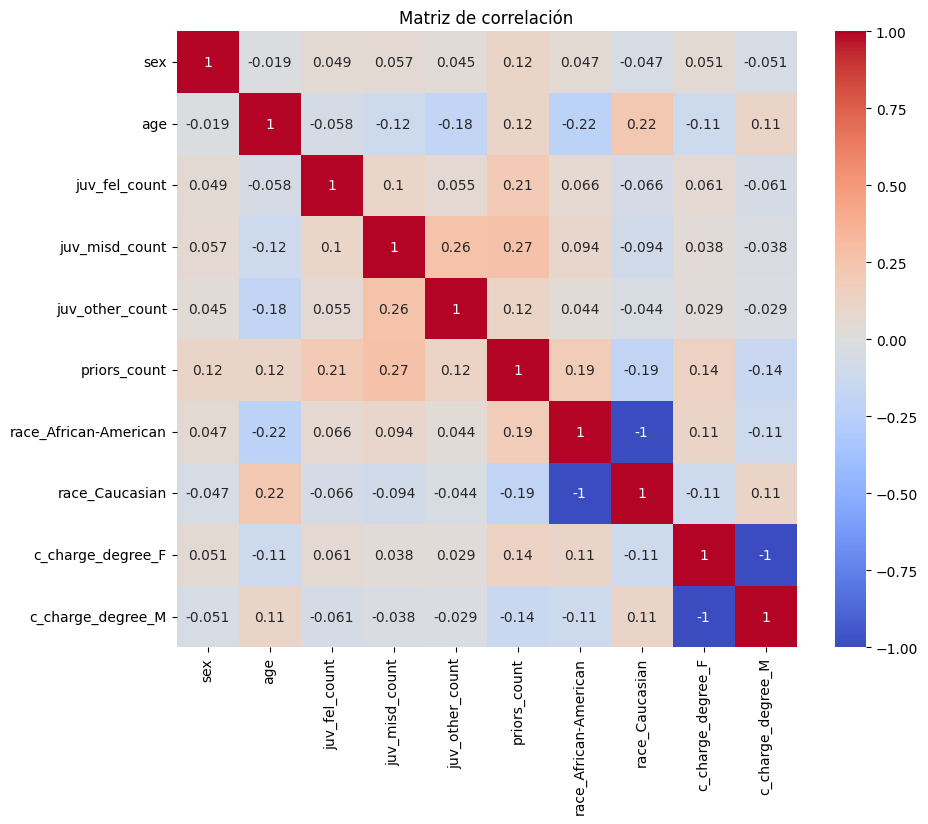

In [24]:
corr = X.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True,
 cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.show()


**Mayoría de correlaciones entre -0.2 y +0.3**:
- No hay multicolinealidad fuerte (no hay pares > 0.8).
- Las variables son moderadamente independientes, lo que favorece tanto modelos lineales como GAMs.

**Observación específica**:
- ``age`` vs ``juv_misd_count`` (-0.12): Los más jóvenes tienden a más delitos menores → posible efecto no lineal con la edad.
- ``juv_misd_count`` vs ``juv_other_count`` (0.26): Ligera correlación
- ``priors_count`` vs ``juv_misd_count`` (0.27): Más antecedentes, más delitos previos; puede haber saturación (no linealidad).
- Perfectamente correlacionadas variables de grado de cargo criminal F (felony) y M (misdemeanor) -> ya que si tiene cargo F, no lo tendrà M
- Igual correlacionadas, persona es afroamericana o caucasica -> ya que si es afroamericano, no es caucasico

Estos dos últimos casos los vamos a juntar, ya que se puede representar en una sola variable.

In [29]:
X = X.drop(columns=["race_Caucasian", "c_charge_degree_M"])
X = X.rename(columns={
    "race_African-American": "is_AfricanAmerican_vs_Caucasian",
    "c_charge_degree_F": "is_Felony_vs_Misdemeanor"
})


Ahora los valores de ``is_AfricanAmerican_vs_Caucasian`` y ``is_Felony_vs_Misdemeanor`` van a ser:
- 1 = African-American, 0 = Caucasian
- 1 = Felony, 0 = Misdemeanor

Aquí podemos ver como se han modificado las variables:

In [7]:
X.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_AfricanAmerican_vs_Caucasian,is_Felony_vs_Misdemeanor,employment
0,0,45,0,0,0,1,0,1,unemployed
1,1,43,0,0,0,2,1,0,unemployed
2,0,26,0,0,0,0,1,1,employed
3,1,35,0,0,0,1,0,1,unemployed
4,1,27,0,0,0,0,1,1,unemployed


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

## Correlación entre variables y objetivo


--- Generando Cuadrícula de Gráficos de Linealidad con Suavizado LOESS ---


/usr/local/lib/python3.12/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide



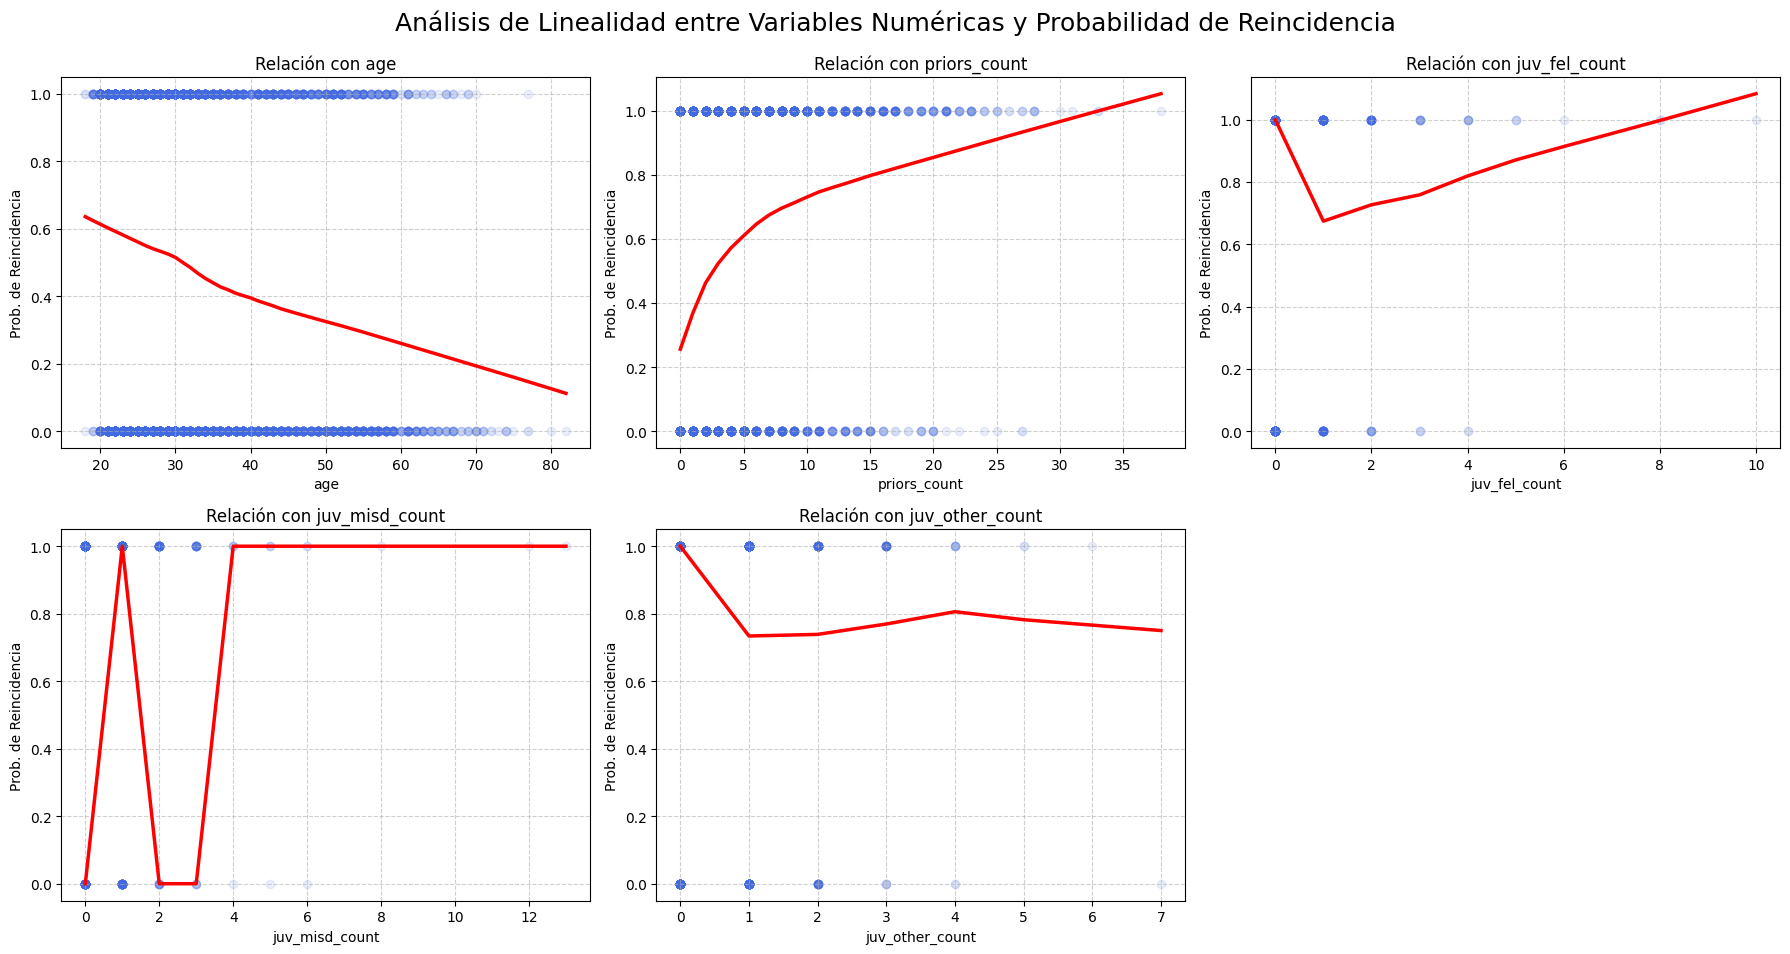

In [31]:
df_combined = X.copy()
df_combined['recid'] = y

# --- 2. Visualización en Cuadrícula ---
# Lista de variables numéricas a analizar
numeric_features = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

print("\n--- Generando Cuadrícula de Gráficos de Linealidad con Suavizado LOESS ---")

# Crear una cuadrícula de 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# Aplanar el array de ejes para iterar fácilmente
axes = axes.flatten()

# Generar cada gráfico en su respectivo eje
for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.regplot(x=feature, y='recid', data=df_combined,
                lowess=True,
                scatter_kws={'alpha': 0.1, 'color': 'royalblue'},
                line_kws={'color': 'red', 'linewidth': 2.5},
                ax=ax)
    ax.set_title(f'Relación con {feature}', fontsize=12)
    ax.set_ylabel('Prob. de Reincidencia')
    ax.set_xlabel(feature)
    ax.grid(True, linestyle='--', alpha=0.6)

# Ocultar ejes que no se usan
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Ajustar el layout y añadir un título general
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Análisis de Linealidad entre Variables Numéricas y Probabilidad de Reincidencia', fontsize=18)
plt.show()

--- Generando Cuadrícula de Gráficos de Barras ---


/tmp/ipython-input-1968205599.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1968205599.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1968205599.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1968205599.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




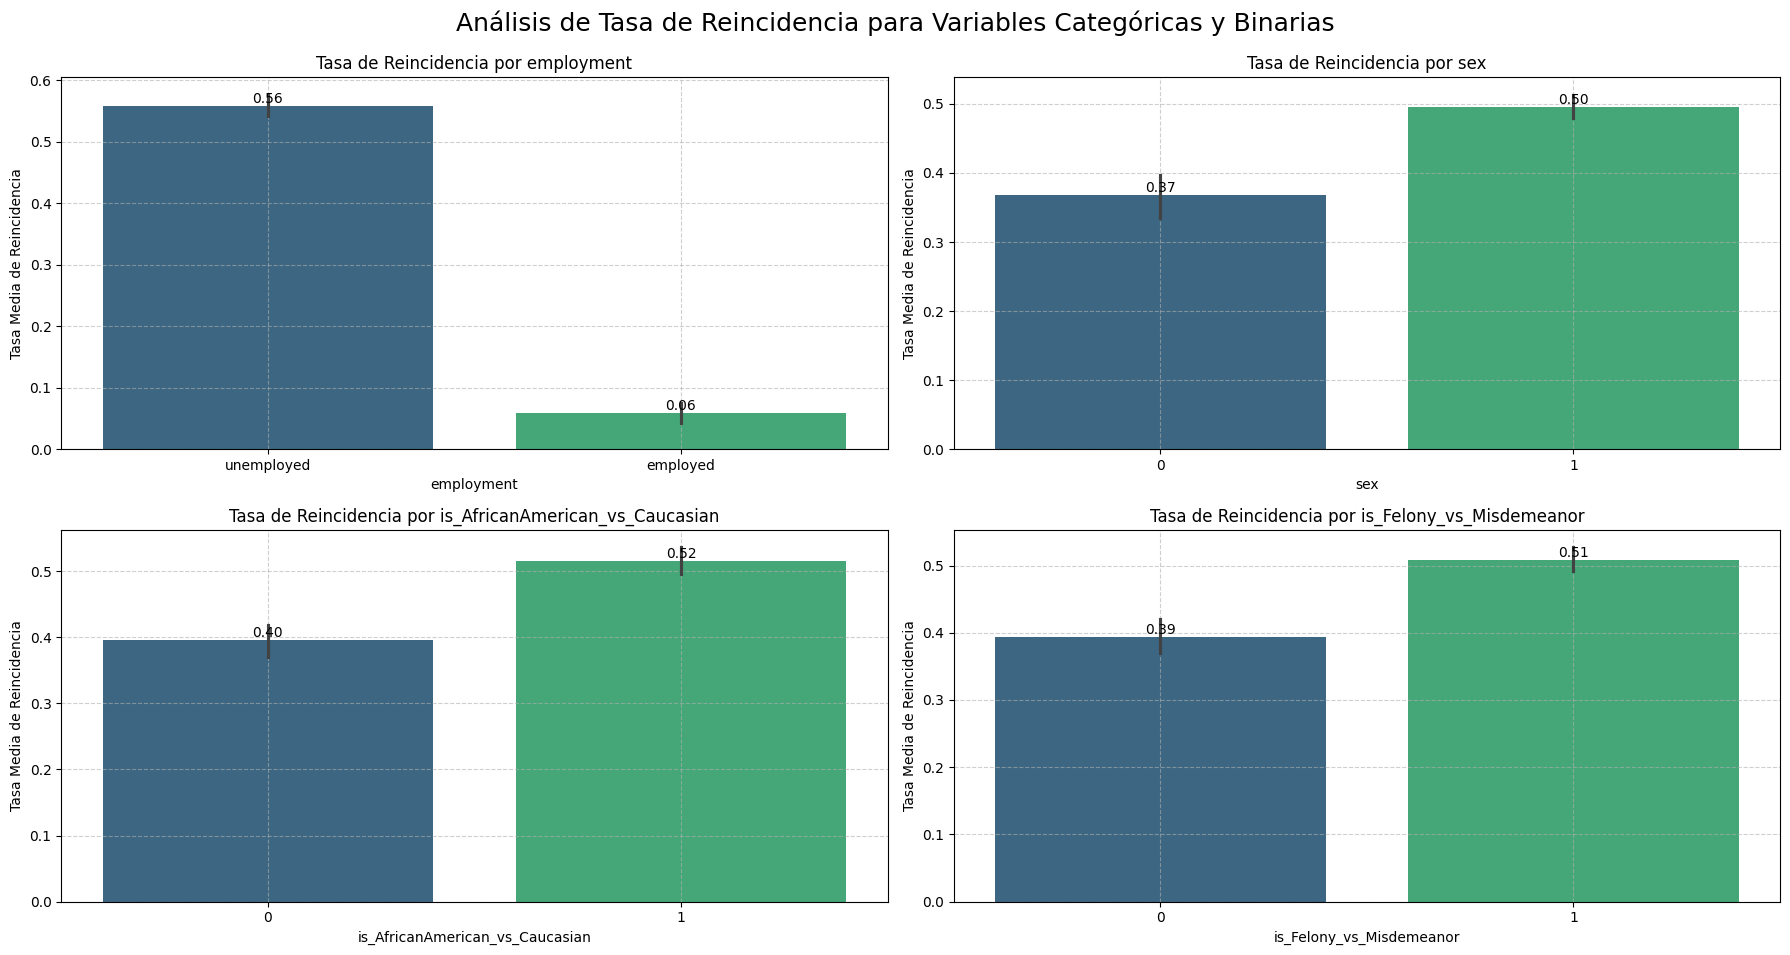

In [32]:
# --- 2. Visualización en Cuadrícula ---
# Identificar columnas a graficar
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
binary_features = [col for col in X.columns if X[col].nunique() == 2 and col not in categorical_features]
features_to_plot = categorical_features + binary_features

print("--- Generando Cuadrícula de Gráficos de Barras ---")

# Crear una cuadrícula de 2 filas y 3 columnas
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# Aplanar el array de ejes para iterar fácilmente
axes = axes.flatten()

# Generar cada gráfico en su respectivo eje
for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.barplot(x=feature, y='recid', data=df_combined, palette='viridis', ax=ax)
    ax.set_title(f'Tasa de Reincidencia por {feature}', fontsize=12)
    ax.set_ylabel('Tasa Media de Reincidencia')
    ax.set_xlabel(feature)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Añadir etiquetas con valores
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Ocultar ejes que no se usan (si el número de gráficos no llena la cuadrícula)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Ajustar el layout para evitar solapamientos y añadir un título general
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Análisis de Tasa de Reincidencia para Variables Categóricas y Binarias', fontsize=18)
plt.show()

- **Empleo**: estar desempleado multiplica casi por diez la probabilidad de reincidir en este dataset. Esta es una señal predictiva muy potente.
- **Otras**: impacto individual es mucho menor en comparación con el del empleo.

Gracias a este estudio, ahora podemos entender como en el árbol de desicion se elige la variable del empleo como nodo raíz, ya que es el qie mejor separa los datos en grupos con diferentes probabilidades de reincidencia.

Observando las anteriores gráficas, podemos concluir que el mejor modelo a elegir es el de la GAM, ya que los modelos lineales asumen que la relación entre cada variable predictora y el resultado es una línea recta, mientras que los GAMs son flexibles y pueden modelar relaciones curvas (no lineales). En el análisis anterior, hemos podido observar que simpre hay variables con relaciones no lineales.

Con GAM podemos conseguir un gran poder predictivo, mucha interpretabilidad y más flexibilidad.

# GAM

In [1]:
!pip install -q interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 16.4 MB/s eta 0:00:00


In [33]:
# --- 4. Definición de la Rejilla de Parámetros para EBM ---
# --------------------------------------------------------
# NOTA: Esta es una rejilla reducida para que se ejecute rápido.
# En un proyecto real, podrías explorar rangos más amplios.
param_grid_ebm = {
    'learning_rate': [0.01, 0.05],
    'max_bins': [32, 64, 128],
    'interactions': [0, 5]  # 0 = GAM puro, 5 = GAM con 5 mejores interacciones
}

# Esquema de validación cruzada estratificada
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 5. Ejecución del GridSearchCV ---
# -----------------------------------
ebm_base = ExplainableBoostingClassifier(random_state=42)

grid_ebm = GridSearchCV(
    estimator=ebm_base,
    param_grid=param_grid_ebm,
    scoring='balanced_accuracy',  # Métrica robusta ante desbalance
    cv=cv_stratified,
    n_jobs=-1,  # Usar todos los núcleos de CPU
    verbose=1
)

print("\nIniciando GridSearchCV para EBM...")
grid_ebm.fit(X_train, y_train)

# --- 6. Resultados y Evaluación ---
# ----------------------------------
print("\n--- Resultados del GridSearchCV para EBM ---")
print("Mejores parámetros encontrados:")
print(grid_ebm.best_params_)
print(f"\nMejor puntuación (balanced_accuracy) en validación cruzada: {grid_ebm.best_score_:.4f}")

# Evaluar el mejor modelo encontrado en el conjunto de test
best_ebm = grid_ebm.best_estimator_
y_pred_best = best_ebm.predict(X_test)

print("\n--- Evaluación del Mejor Modelo EBM en el Conjunto de Test ---")
print(f"Accuracy (test): {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Balanced Accuracy (test): {balanced_accuracy_score(y_test, y_pred_best):.4f}")
print("\n== Classification report (test) ==")
print(classification_report(y_test, y_pred_best))


Iniciando GridSearchCV para EBM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Resultados del GridSearchCV para EBM ---
Mejores parámetros encontrados:
{'interactions': 5, 'learning_rate': 0.05, 'max_bins': 64}

Mejor puntuación (balanced_accuracy) en validación cruzada: 0.7191

--- Evaluación del Mejor Modelo EBM en el Conjunto de Test ---
Accuracy (test): 0.7206
Balanced Accuracy (test): 0.7235

== Classification report (test) ==
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       674
           1       0.68      0.77      0.72       593

    accuracy                           0.72      1267
   macro avg       0.72      0.72      0.72      1267
weighted avg       0.73      0.72      0.72      1267


--- Generando Explicación Global del Modelo EBM Optimizado ---


El modelo EBM ha demostrado un rendimiento sólido y equilibrado en el conjunto de prueba, con una Precisión Balanceada (Balanced Accuracy) de 0.7235.

- **Rendimiento Equilibrado**: El modelo funciona bien tanto para predecir la reincidencia como la no reincidencia. Esto se confirma al observar que los f1-score para ambas clases son idénticos (0.72), y la Balanced Accuracy (72.4%) es muy similar a la Accuracy general (72.1%).

- **Fortaleza en la Detección de Riesgo**: La principal fortaleza del modelo es su capacidad para identificar a los individuos que efectivamente reinciden, logrando un recall del 77% para la clase 1. Esto lo hace una herramienta valiosa para la detección de riesgo.

- **Fiabilidad en Predicciones de No Reincidencia**: Cuando el modelo predice que una persona no reincidirá (clase 0), su fiabilidad es alta, con una precision del 77%

In [34]:
# --- 7. Explicabilidad del Modelo Optimizado ---
# ---------------------------------------------
print("\n--- Generando Explicación Global del Modelo EBM Optimizado ---")
ebm_global_optimized = best_ebm.explain_global(name='EBM_Optimized_Global')
show(ebm_global_optimized)

print("\n--- Generando Explicación Local para 5 casos ---")
ebm_local = best_ebm.explain_local(X_test[:5], y_test[:5], name='EBM_Local')
show(ebm_local)


--- Generando Explicación Global del Modelo EBM Optimizado ---



--- Generando Explicación Local para 5 casos ---


# Modelo lineal

In [35]:
# --- 3. Preprocesamiento para Modelo Lineal ---
# Identificar tipos de columnas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Crear transformadores (StandardScaler para numéricas, OneHotEncoder para categóricas)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 4. Definición del Pipeline y GridSearchCV ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Definir la rejilla de parámetros
param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Configurar el GridSearchCV
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_lr = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid_lr,
    scoring='balanced_accuracy',
    cv=cv_stratified,
    n_jobs=-1,
    verbose=1
)

print("\nIniciando GridSearchCV para Regresión Logística...")
grid_lr.fit(X_train, y_train)

# --- 5. Resultados y Evaluación ---
print("\n--- Resultados del GridSearchCV para Regresión Logística ---")
print("Mejores parámetros encontrados:")
print(grid_lr.best_params_)
print(f"\nMejor puntuación (balanced_accuracy) en validación cruzada: {grid_lr.best_score_:.4f}")

# Evaluar el mejor modelo en el conjunto de test
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("\n--- Evaluación del Modelo de Regresión Logística en el Conjunto de Test ---")
print(f"Accuracy (test): {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Balanced Accuracy (test): {balanced_accuracy_score(y_test, y_pred_lr):.4f}")
print("\n== Classification report (test) ==")
print(classification_report(y_test, y_pred_lr))


Iniciando GridSearchCV para Regresión Logística...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

--- Resultados del GridSearchCV para Regresión Logística ---
Mejores parámetros encontrados:
{'classifier__C': 10}

Mejor puntuación (balanced_accuracy) en validación cruzada: 0.7147

--- Evaluación del Modelo de Regresión Logística en el Conjunto de Test ---
Accuracy (test): 0.7017
Balanced Accuracy (test): 0.7067

== Classification report (test) ==
              precision    recall  f1-score   support

           0       0.77      0.63      0.69       674
           1       0.65      0.79      0.71       593

    accuracy                           0.70      1267
   macro avg       0.71      0.71      0.70      1267
weighted avg       0.71      0.70      0.70      1267



El modelo lineal optimizado funciona como un sólido punto de referencia, alcanzando una Precisión Balanceada (Balanced Accuracy) de 70.67%.

- **Buen Detector de Reincidencia**: La principal fortaleza del modelo es su alta capacidad para identificar a los individuos que efectivamente reinciden, logrando un recall del 79% para la clase 1.

- **Rendimiento Desigual**: Aunque es bueno detectando reincidentes, tiene más dificultades para identificar correctamente a todos los que no reinciden, con un recall del 63% para la clase 0. Esto indica una mayor tendencia a generar "falsas alarmas" en comparación con el modelo GAM.

- **Conclusión**: Es un modelo útil, pero su rendimiento general es inferior al del GAM, lo que sugiere que su incapacidad para modelar las relaciones no lineales limita su precisión.

## Conclusiones: ¿QUé es mejor, modelo lineal o modelo GAM?

- El GAM (EBM) es el ganador: Con una Balanced Accuracy del 72.35%, el GAM es el modelo con el mejor rendimiento general. Aunque la diferencia no es abismal, es una mejora clara y consistente sobre los otros dos modelos.

- ¿Por qué gana el GAM?: Su principal ventaja es que logra el mejor equilibrio. Es casi tan bueno como los otros modelos para detectar a los que sí reinciden (Recall del 77%), pero es significativamente mejor para identificar correctamente a los que no van a reincidir (Recall del 68%). En otras palabras, genera menos "falsas alarmas" que los otros dos.

- El Modelo Lineal es un Buen Baseline, pero Limitado: La Regresión Logística (70.67%) funciona ligeramente mejor que el Árbol de Decisión (70.19%). Demuestra ser un modelo base sólido. Sin embargo, su rendimiento inferior al del GAM confirma nuestra hipótesis inicial: al no poder modelar las relaciones curvas de la edad y el número de antecedentes, pierde algo de precisión.

- Conclusión Final: Rendimiento + Interpretabilidad: El GAM (EBM) no solo ha demostrado ser el modelo más preciso, sino que también ofrece una interpretabilidad superior al permitirnos visualizar y entender las complejas relaciones no lineales de los datos. La mejora en las métricas es la prueba cuantitativa de que capturar esas curvas (algo que el modelo lineal no puede hacer) es beneficioso para el rendimiento del modelo.